In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

snowflow_data_fn = 'boise_river_snow2flow.csv'

In [2]:
snowflow_data_df = pd.read_csv(snowflow_data_fn, index_col='datetime', parse_dates=True)
snowflow_data_df

,prec_mm,tavg_degc,swe_mm,flow_cms
datetime,,,,
2000-10-01,5.08,5.0,0.00,8.693589
2000-10-02,0.00,2.6,0.00,9.061721
2000-10-03,0.00,0.9,0.00,8.806861
2000-10-04,0.00,1.7,0.00,8.778543
2000-10-05,0.00,-0.5,0.00,8.750225
...,...,...,...,...
2025-09-26,0.00,8.9,0.00,7.674145
2025-09-27,0.00,8.7,0.00,7.617510
2025-09-28,0.00,11.5,0.00,7.617510


In [16]:
mon_prec_sum = snowflow_data_df['prec_mm'].groupby([snowflow_data_df.index.year,snowflow_data_df.index.month]).sum().values
mon_temp_avg = snowflow_data_df['tavg_degc'].groupby([snowflow_data_df.index.year,snowflow_data_df.index.month]).mean().values
mon_temp_maxrat = snowflow_data_df['tavg_degc'].groupby([snowflow_data_df.index.year,snowflow_data_df.index.month]).max().values / mon_temp_avg
mon_temp_minrat = snowflow_data_df['tavg_degc'].groupby([snowflow_data_df.index.year,snowflow_data_df.index.month]).min().values / mon_temp_avg
mon_swe_max = snowflow_data_df['swe_mm'].groupby([snowflow_data_df.index.year,snowflow_data_df.index.month]).max().values
mon_swe_range = (snowflow_data_df['swe_mm'].groupby([snowflow_data_df.index.year,snowflow_data_df.index.month]).max() 
                 - snowflow_data_df['swe_mm'].groupby([snowflow_data_df.index.year,snowflow_data_df.index.month]).min()).values
mon_swe_begend = (snowflow_data_df['swe_mm'].groupby([snowflow_data_df.index.year,snowflow_data_df.index.month]).first()
                 - snowflow_data_df['swe_mm'].groupby([snowflow_data_df.index.year,snowflow_data_df.index.month]).last()).values
mon_flow_avg = snowflow_data_df['flow_cms'].groupby([snowflow_data_df.index.year,snowflow_data_df.index.month]).mean().values
mon_flow_avg_ln = np.log(mon_flow_avg)

In [17]:
snowflow_data_months = snowflow_data_df.groupby([snowflow_data_df.index.year,snowflow_data_df.index.month]).first().index.get_level_values(1).values

mon_sin = np.sin(snowflow_data_months/12 * (2 * np.pi))
mon_cos = np.cos(snowflow_data_months/12 * (2 * np.pi))

In [29]:
Xdata = {
    'mon_sin': mon_sin[0:-1], 
    'mon_cos': mon_cos[0:-1], 
    'mon_prec_sum': mon_prec_sum[0:-1], 
    'mon_temp_avg': mon_temp_avg[0:-1],
    'mon_temp_maxrat': mon_temp_maxrat[0:-1],
    'mon_temp_minrat': mon_temp_minrat[0:-1], 
    'mon_swe_max': mon_swe_max[0:-1], 
    'mon_swe_range': mon_swe_range[0:-1],
    'mon_swe_begend': mon_swe_begend[0:-1], 
    'mon_flow_avg_ln': mon_flow_avg_ln[0:-1]
}

train = pd.DataFrame(Xdata)

In [30]:
scaler = StandardScaler()

scaler.fit(train)

X_transformed = scaler.transform(train)

In [31]:
y = mon_flow_avg_ln[1:]
y.shape

(299,)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [41]:
# 3. Create DMatrix objects for XGBoost
# DMatrix is an optimized data structure for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=['mon_sin',
                                                            'mon_cos',
                                                            'mon_prec_sum',
                                                            'mon_temp_avg',
                                                            'mon_temp_maxrat',
                                                            'mon_temp_minrat',
                                                            'mon_swe_max',
                                                            'mon_swe_range',
                                                            'mon_swe_begend',
                                                            'mon_flow_avg_ln'
                                                            ])
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=['mon_sin',
                                                         'mon_cos',
                                                         'mon_prec_sum',
                                                         'mon_temp_avg',
                                                         'mon_temp_maxrat',
                                                         'mon_temp_minrat',
                                                         'mon_swe_max',
                                                         'mon_swe_range',
                                                         'mon_swe_begend',
                                                         'mon_flow_avg_ln'
                                                        ])

In [90]:
# 4. Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # Objective for regression (mean squared error)
    'eval_metric': 'rmse',            # Evaluation metric (Root Mean Squared Error)
    'max_depth': 5,                  # Maximum depth of a tree
    'eta': 0.01,                      # Learning rate (step size shrinkage)
    'subsample': 0.6,                 # Subsample ratio of the training instance
    'colsample_bytree': 0.8,          # Subsample ratio of columns when constructing each tree
    'seed': 42                        # Random seed for reproducibility
}

In [91]:
# 5. Train the XGBoost model
num_rounds = 500  # Number of boosting rounds (trees)
model = xgb.train(params, dtrain, num_rounds)

In [92]:
# 6. Make predictions on the test set
y_pred = model.predict(dtest)

# 7. Evaluate the model
mse = mean_squared_error(np.exp(y_test), np.exp(y_pred))
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

Mean Squared Error: 85.0238
Root Mean Squared Error: 9.2208


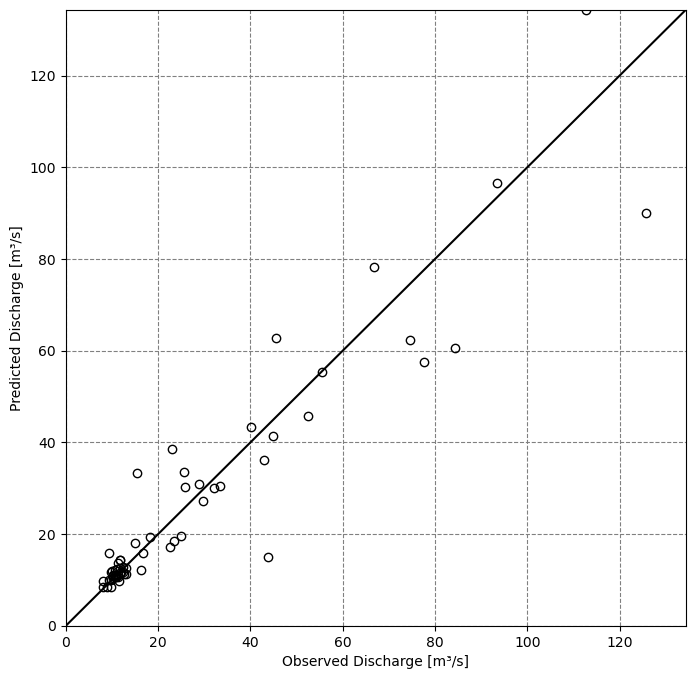

In [93]:
one2one = np.linspace(0,np.max((np.exp(y_pred).max(),np.exp(y_test).max())),100)

fig = plt.figure(figsize=(8,8))
plt.plot(np.exp(y_test),np.exp(y_pred), marker='o', markerfacecolor='None', markeredgecolor='k', linestyle='None')
plt.plot(one2one,one2one,'k-')
plt.xlim([0, one2one.max()])
plt.ylim([0, one2one.max()])
plt.grid('on',color='grey', linestyle='--')
plt.xlabel('Observed Discharge [m\u00b3/s]')
plt.ylabel('Predicted Discharge [m\u00b3/s]')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

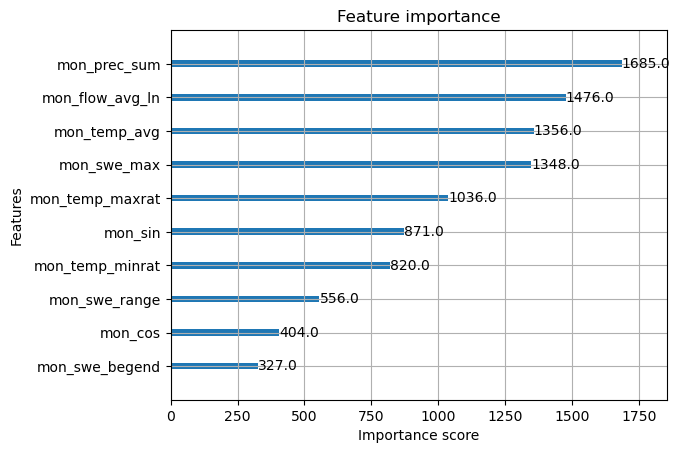

In [94]:
xgb.plot_importance(model)

In [39]:
train

,mon_sin,mon_cos,mon_prec_sum,mon_temp_avg,mon_temp_maxrat,mon_temp_minrat,mon_swe_max,mon_swe_range,mon_swe_begend,mon_flow_avg_ln
0,-8.660254e-01,0.500000,137.16,0.706452,13.589041,-9.059361,93.98,93.98,-93.98,2.369864
1,-5.000000e-01,0.866025,76.20,-8.893333,0.416042,1.652924,170.18,76.20,-76.20,2.396915
2,-2.449294e-16,1.000000,139.70,-7.551613,0.450235,2.039299,309.88,139.70,-139.70,2.326402
3,5.000000e-01,0.866025,63.50,-7.893548,0.114017,2.369023,370.84,60.96,-60.96,2.340133
4,8.660254e-01,0.500000,58.42,-9.032143,0.033215,1.937525,431.80,58.42,-58.42,2.316969
...,...,...,...,...,...,...,...,...,...,...
294,8.660254e-01,-0.500000,55.88,-0.573333,-9.069767,15.697674,1016.00,76.20,50.80,4.345595
295,5.000000e-01,-0.866025,27.94,4.354839,2.525926,-0.252593,927.10,576.58,576.58,4.699827
296,1.224647e-16,-1.000000,10.16,9.840000,1.595528,0.091463,314.96,314.96,314.96,4.151010
297,-5.000000e-01,-0.866025,17.78,14.412903,1.290510,0.624440,0.00,0.00,0.00,2.824787
